In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pprint
import scipy
from scipy.optimize import curve_fit
from IPython import display
%matplotlib inline

In [2]:
import matplotlib as mpl

mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

In [3]:
def exp(x,a,b):
    return a*np.exp(b*x)

# The Ising model in 2D
The Hamiltonian of the Ising model is

$$
\mathcal{H} = -\sum_{\langle ij \rangle} J s_i s_j - H \sum_i s_i
$$

In this exercise, we focus on the case $J=1, H=0$, that is, a ferromagnetic system with no external field. Remember that the sum $\langle ij \rangle$ runs over neighbouring sites only. In our 2D lattice, each site has 4 neighbours. 

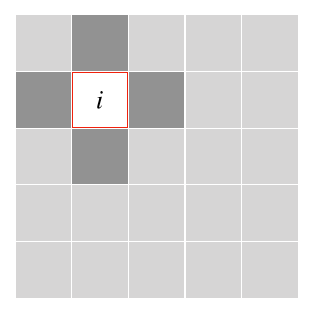 


We will work with **periodic boundary conditions**, so that all spins have 4 neighbours. 

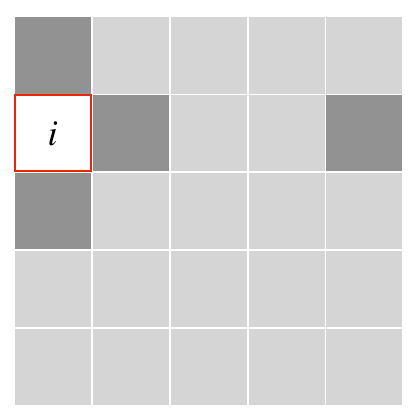 


# The Metropolis algorithm
We will build a simple implementation of the **Metropolis** algorithm for the 2D Ising model. 

As a reminder, a single update of the Metropolis algorithm works as follows:

1. Pick a site $(i, j)$ at random.
2. Calculate the energy change $\Delta E$ that flipping the spin $s_{ij}$ would produce.
3. If $\Delta E <0$, flip the spin with probability $1$.
4. If $\Delta E >0$, flip the spin with probability $e^{-\beta \Delta E}$.

### Exercice 4.1
Write a function that, given an integer $N$, returns an $N \times N$ array whose elements are randomly picked from {-1, 1}. 

In [4]:
class Ising:
    def __init__(self, N=10, J=1, h=0, configure=True):
        """
        """
        self.N = N
        self.J = J
        self.h = h
        self.configured = False
        if configure:
            self.create_initial_config()
    
    def create_initial_config(self):
        self.config = np.random.rand(self.N, self.N)
        self.config = np.array([[-1 if self.config[i][j] < 0.5 else 1 for i in range(len(self.config[j]))] for j in range(len(self.config))])
        self.configured = True
        return self.config
    
    def graph_config(self, figsize=(8,8)):
        if self.configured:
            fig, ax = plt.subplots(figsize=figsize)
            plt.title("Spin Configuration")
            plt.imshow(self.config)
    
    def metropolis_single_update(self, temperature:float):
        assert temperature >= 0, "Temperature cannot be negative."
        assert self.config.shape == (self.N, self.N), "Spin configuration must be a squared matrix"
        if not self.configured:
            self.create_initial_config()
        beta = 1/temperature
        i,j = np.random.randint(0,self.N-1,size=2)
        s = self.config[i,j]
        #E1 = self.specific_energy(i,j) # Stato iniziale della transizione
        #self.flip_spin(i,j) # Flip di spin casuale
        #E2 = self.specific_energy(i,j) # 
        deltaE = self.energy_change(i,j)
        if deltaE < 0:
            #accepted
            return deltaE 
        else:
            r = np.random.rand()
            p = np.exp(-deltaE/temperature)
            if r <= p:
                #accepted
                return deltaE
            else:
                # rejected -> reflip
                self.flip_spin(i,j)
                return 0
                
                
        
    def energy_change(self, i:int, j:int):
        if self.configured:
            return -2*self.config[i][j]*(self.config[self.pbc(i-1)][self.pbc(j)] +
                          self.config[self.pbc(i+1)][self.pbc(j)] +
                          self.config[self.pbc(i)][self.pbc(j-1)] +
                          self.config[self.pbc(i)][self.pbc(j+1)])
        else:
            raise RuntimeError("Trying to calculate energy of empty configuration.")
    
    def total_energy(self):
        """
        Compute the energy of a configuration.

        The energy is defined as $E = -\sum_{(a, b)} S_a S_b$,    
        where the sum runs over pairs of adjacent spins.

        Parameters
        ----------
        config : np.array, (N, N)
            The system configuration.


        Returns
        -------
        E : float
            The energy of the configuration.
        """
        # list of pairs of adjacent sites as four-element tuples:
        # (i1, j1, i2, j2) represents two adjacent sites located
        # at (i1, j1) and (i2, j2)
        horizontal_edges = [
            ( i, (j-1)%self.N ,i, (j+1)%self.N)
            for i in range(self.N) for j in range(self.N)
        ]
        vertical_edges = [
            ((i-1)%self.N, j, (i+1)%self.N, j)
            for i in range(self.N) for j in range(self.N)
        ]
        # summing lists in python concatenates them
        # [1, 2, 3] + [4, 5] = [1, 2, 3, 4, 5]
        edges = horizontal_edges + vertical_edges
        E = 0
        for i1, j1, i2, j2 in edges:
            E -= self.config[i1, j1]*self.config[i2, j2]
        return E

    def get_energy_evolution(self,temperature, n_updates=50000):
        """
        Compute the energy evolution of a 2D Ising instance.

        Parameters
        ----------
        N : int
            The system size.
        T : float
            The temperature.
        n_updates : int
            Number of Metropolis updates.

        Returns
        -------
        Es : np.array, (n_updates, )
        """
        
        energies = list()
        for i in range(n_updates):
            self.metropolis_single_update(T_c)
            ene = self.total_energy()
            energies.append(ene)
        return np.array(energies)

    def flip_spin(self,i,j):
        if self.configured:
            self.config[i,j] *= -1
        else:
            raise RuntimeError("Trying to flip spin of empty configuration.")
        
    def pbc(self, i):
        """
        Periodic Boundary Conditions: ...
        Parameters:
            - i (int)
                1D index of spin site in the configuration
        Return:
            The index of the spin with PBC applied.
        """
        return i%self.N
        
        

Let us create an initail configuration with our `create_inital_config_function`. A system size of $N=100$ will be enough.

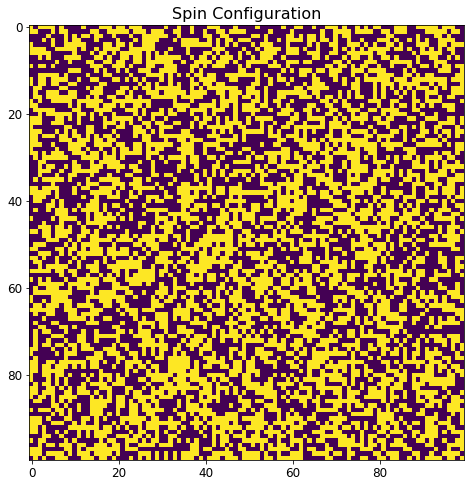

In [5]:
ising = Ising(100)
ising.graph_config()

To plot our system we can use `plt.imshow()`, as follows:

### Exercise 4.2
We will write our Metropolis update function. Given a site $(i, j)$, what is the change in energy $\Delta E$ that flipping $S(i, j)$ entails?
Recall that only 4 spins are connected to $(i, j)$, so you don't need to compute the energy of the whole system.

#### <span style=color:red> Answer </span>
The change in energy between two different states depends strictly from the terms that directly involve the flipped spin. In fact, the difference in energy between two spin configuration states $\mu$ and $\nu$ can be calculated as a difference of the Hamiltonians, obtaining: $$E_{\nu} - E_{\mu} = -J\sum_{i n.n. to k} s_i^{\mu}(s_k^{\nu} - s_k^{\mu}),$$ where the sum is computed on the nearest neighbours of the flipped spin k.<br>
Of course, the configuration has a finite size, therefore calculating of the nearest neighbour in the probability of transitioning from state $\mu$ to state $\nu$ must include some sort of periodic boundary conditions.
Since
$s_k^{\nu} - s_k^{\mu} = -2s_k^{\mu}$, an efficient way to calculate the energy difference is: 
$$ E_{\nu} - E_{\mu} = 2Js_k^{\mu} \sum_{i n.n. k} s_i^{\mu}$$

### Exercise 4.3
Write a function called `metropolis_single_update()`.  
The **input** should be:

+ *config*, a lattice configuration as an (N, N) array.
+ *T*, the temperatue.

There is no need to return anything since in python, functions can modify its input, so we will be updating config *inplace*. But it is useful to return the energy change $\Delta E$ if one later wants to track the energy during simulations. To simplify things, we will use **periodic boundary conditions** (in python, the modulo operator is `%`).

In [6]:
for i in range(100):
    x = ising.metropolis_single_update(1)

## Visualizing the simulation on real time
To see if our Metropolis algorithm works, you might want to simulate systems at different temperatures, and observe how the configuration evolves trought time. To do this you need the `display` module. Below you will find an example of how to use it.

For the 2D Ising model, the **critical temperature** is known to be
$$
T_c = \frac{2}{\ln(1+\sqrt{2})} \simeq 2.2691853...
$$
(with $k_B=1$). Try executing the cell below at different values of the temperature, for different system size. 

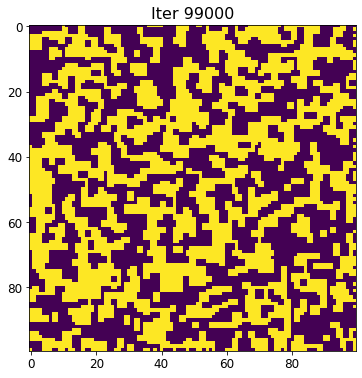

In [7]:
T_c = 2/np.log(1+np.sqrt(2))

# create initial random configuration
newIsing = Ising(N=100)

# set up figure, plot first frame
fig, ax = plt.subplots(1, 1, figsize=(8,6))
# draw the initial configuration,
# naming the plot "im".
im = ax.imshow(newIsing.config)

for t in range(100000):
    # update the system
    DeltaE = newIsing.metropolis_single_update(temperature=T_c)
    # replot every 1000 MC updates
    if t%1000==0:
        # update the data of the plot (not the whole figure!)
        ax.set_title(f"Iter {t}")
        im.set_data(newIsing.config)
        # rerender
        display.display(plt.gcf())
        display.clear_output(wait=True)

### Exercice 4.4
Write a function that computes the energy of a configuration, and another that tracks its evolution over time.

In [8]:
# See class implementation

### Exercise 4.5
Compute the energy of your system during a long simulation, and plot it as a function of time. **Tip** Use logarithmic x-axis!

In [9]:
ising = Ising(N=100)
energy_evolution = ising.get_energy_evolution(T_c, n_updates=1000)


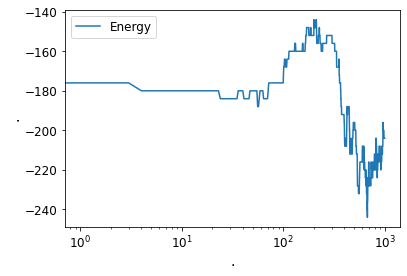

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.semilogx(energy_evolution, label="Energy")
ax.set_xlabel(".")
ax.set_ylabel(".")
ax.legend()
plt.show()

### Exercise 4.6
Can you distinguish two qualitatively different periods? What do they correspond to?

*Your answer here*

# Efficient Metropolis
Our implementation of the Ising model was not very efficient. To do this exercice, we will use part of the code from Sethna's book, which is much more efficient and can be found here:

[Sethan's book computer exercices](http://pages.physics.cornell.edu/~myers/teaching/ComputationalMethods/ComputerExercises/Ising/Ising.html)

To import code from an external file, we need to add its directory to the PATH



In [11]:
import sys
sys.path.append("code/")
from ising_sethna import IsingModel

Their implementation is based on a `Class`, which means we need to instantiate the model. For instance:

In [12]:
# create an instance of IsingModel
ising = IsingModel(N=100)

In [13]:
# the state of the system is stored in .lattice
ising.lattice

array([[1, 1, 0, ..., 1, 0, 1],
       [1, 1, 1, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 1, 1],
       [0, 1, 1, ..., 1, 0, 1]])

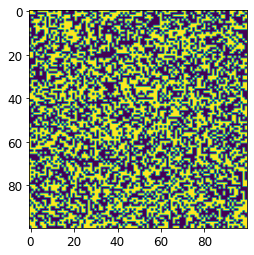

In [14]:
mpl.rcParams['axes.spines.right'] = True
mpl.rcParams['axes.spines.top'] = True
plt.imshow(ising.lattice)

Notice that this implementation uses 0, 1 spins instead of -1, 1 as we are used to! To run the simulation, we call the `.SweepMetropolis()` method. If you go to the source file at `SethnasBookCode/Ising.py`, you can inspect all the code. You will notice that all `.Sweep...()` methods perform $N^2$ updates per time-step. This is useful because time-scales become independent of system size.

In [15]:
ising.SweepMetropolis(nTimes=100)

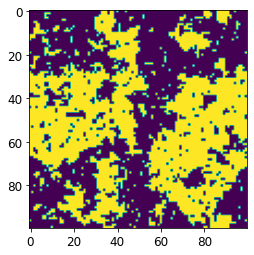

In [16]:
plt.imshow(ising.lattice)

The cell bellow will display 3 systems side-by-side, running at different temperatures. All parameters are set at the top. Try changing some values and see what happens.

In [17]:
#################
# set parameters
system_size = 100
H = 0.0
T_below = 1.5
T_critical = 2.269185314213022
T_above = 3.5
n_sweeps = 100
###############

# create three instances of IsingModel
ising_below = IsingModel(N=system_size, T=T_below, H=H)
ising_critical = IsingModel(N=system_size, T=T_critical, H=H)
ising_above = IsingModel(N=system_size, T=T_above, H=H)

# give them names
isings = [ising_below, ising_critical, ising_above]
labels = ["below $T_c$", "at $T_c$", "above $T_c$"]

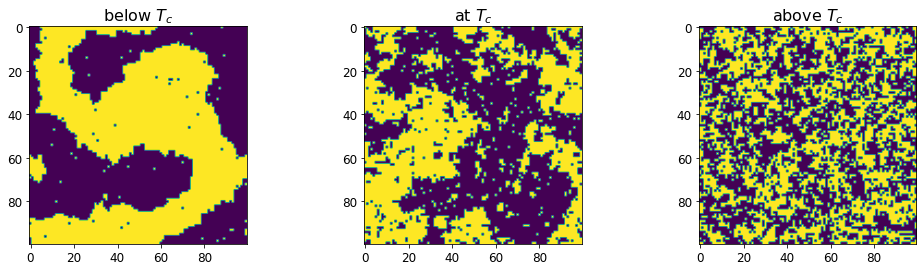

In [18]:
fig, axx = plt.subplots(1, 3, figsize=(17,4))
heatmap = {}
for ax, ising, label in zip(axx, isings, labels):
    heatmap[label] = ax.imshow(ising.lattice)
    ax.set_title(label, fontsize=16)

for _ in range(n_sweeps):
    for ax, ising, label in zip(axx, isings, labels):
        ising.SweepMetropolis(nTimes=1)
        heatmap[label].set_data(ising.lattice)
    display.display(plt.gcf())
    display.clear_output(wait=True)

### Exercice 4.7
How much faster is Sethna's implementation with respect to ours? Use the cell magic `%%timeit` to measure how long a command takes to execute.

To do a fair comparison, remember to take into account what "one update" means for each case.

In [19]:
%%timeit
myTimedIsing = Ising(N=50)
for i in range(50*50):
    x = myTimedIsing.metropolis_single_update(T_critical)

31.3 ms ± 306 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
%%timeit
sethnaTimedIsing = IsingModel(N=50, T=T_critical, H=0)
sethnaTimedIsing.SweepMetropolis()

7.17 ms ± 108 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


*Your answer here*

#### Extending Sethna's model


## Magnetization
We will now compute the magnetization $M$ as a function of the temperature $T$. To speed up simulations even more, we will use the Wolff algorithm, which Sethna's code already implements in the `.SweepWolff()` method.

### Exercise 4.8
For a system of size $N=100$, approximately how many sweeps of the Wolff algorithm are necessary in practice to be in equilibrium? Try starting with smaller values of $N$, and increase gradually. 

In [21]:
def find_equilibrium(lattice:np.ndarray):
    result = np.all(lattice == lattice[0][0])
    return result

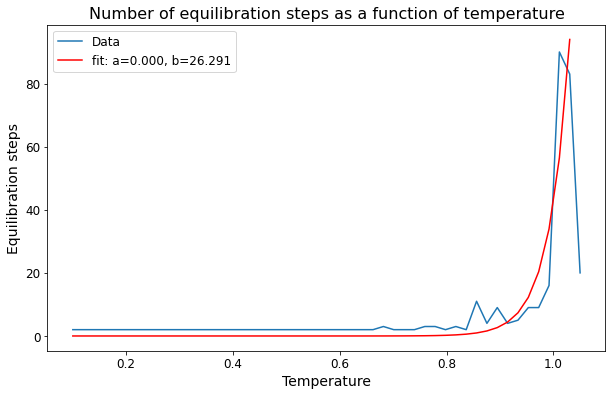

In [22]:
N_wolff = 100
temps = np.linspace(0.1,1.05,num=50)
eq = list()
for t in temps:
    isingWolff = IsingModel(N=N_wolff,H=0, T=t)
    for i in range(10000):
        isingWolff.SweepWolff()
        if find_equilibrium(isingWolff.lattice):
            eq.append(i)
            break
popt, pcov = curve_fit(exp, temps[:-1], eq[:-1])

fig, ax = plt.subplots(figsize=(10,6))
plt.plot(temps, eq, label="Data")
plt.plot(temps[:-1], exp(temps[:-1], *popt), 'r-', label='fit: a=%5.3f, b=%5.3f' % tuple(popt))
plt.title("Number of equilibration steps as a function of temperature")
plt.xlabel("Temperature")
plt.ylabel("Equilibration steps")
plt.legend()
plt.show()

By plotting the configuration at each step of the algorithm, one may visually come to a conclusion about the equilibrium of the Ising model. 

### Exercise 4.9
Write a function that computes the magnetization of a 2D Ising system after certain equilibration period.

In [23]:
def calculate_magnetization(model=None, system_size=None, temperature=None, equilibration_time=None):
    """
    Calculate the magnetization of a 2D Ising model.
    
    Parameters
    ----------
    system_size : int
        The lattice size.
    temperature : float
        The simulation temperature.
    equilibration_time : int
        Number of Wolff sweeps before measuring M.
        
    """
    # instantiate model
    if model is None:
        model = IsingModel(N=system_size, T=temperature)
    else:
        assert system_size is None and temperature is None
    # equilibrate
    for i in range(equilibration_time):
        model.SweepWolff()
    # compute magnetization
    m = 0
    for i in range(model.N):
        for j in range(model.N):
            if model.lattice[i][j] == 1:
                m += 1
            else:
                m -= 1
    return m


### Exercise 4.10
+ Compute the magnetization for a system of size $N=64$, for diverent values of $T\in[1.5, 3.5]$.
+ Remember to choose wisely the equilibration time!
+ Plot $|M|$ as a function of $T$, and mark the critical temperature in your plot using the `plt.axvline()` function.

In [27]:
# define range of temperatures
temperatures = np.linspace(1.5, 3.5, num=40)
# system size
system_size = 64
# equilibration time
equilibration_time = 150

# loop over temperatures, compute magnetizations
magnetizations = []
for temperature in temperatures:
    magnetization = calculate_magnetization(system_size=system_size, temperature=temperature, equilibration_time=equilibration_time)
    magnetizations.append(magnetization)

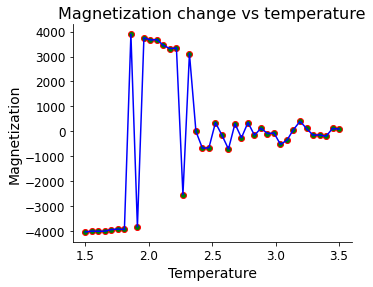

In [28]:
# define critical temperature

T_c = 2. / np.log(1. + np.sqrt(2.))

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.scatter(
    temperatures,
    magnetizations,
    # style keywords
    edgecolors="r",
    color="green"
)
plt.plot(
    temperatures,
    magnetizations,
    color="blue"
)
"""
ax.axvline(
    ...,
    # style keywords
    c=..., lw=..., ls=...
)
"""
ax.set_title("Magnetization change vs temperature")
ax.set_xlabel("Temperature")
ax.set_ylabel("Magnetization")
plt.show()

## Susceptibility and Specific Heat


In this exercice, we will compute the susceptibility $\chi$ and the specific heat $C$. Using formula (6.13) in the book, we have that
$$
C = \frac{1}{T^2} \left\langle (E - \langle E \rangle)^2 \right\rangle.
$$
Remember that this is only valid in **equilibrium**, which means that we can only measure energy fluctuations **after a transient** equilibration time.

### Exercise 4.11
Find a convenient formula to measure the susceptibility $\chi$ in a simulation.

The susceptibility $\chi$ of a system can be found by taking the square of the magnetization, so: $$\chi = \frac{1}{k_B T}\sum_{i=0}^{N} m^2$$

### Exercise 4.12
Write a function that computes the energy of an Ising configuration.

As usually, you can use the **template** below if it helps you, or if you prefer you can also write **your own function** from scratch.

In [24]:
def compute_energy(ising):
    """Compute the energy of an ising object."""
    config = ising.lattice*2-1
    N = len(config)
    
    horizontal_edges = [
        ( i, (j-1)%N ,i, (j+1)%N)
        for i in range(N) for j in range(N)
    ]
    vertical_edges = [
        ((i-1)%N, j, (i+1)%N, j)
        for i in range(N) for j in range(N)
    ]
    edges = horizontal_edges + vertical_edges
    E = 0
    for i1, j1, i2, j2 in edges:
        E -= config[i1,j1]*config[i2,j2]
    return E / N**2

### Exercise 4.13
Write a function that computes the susceptibility and the specific heat of a 2D Ising system. You might use the Wolff algorithm to speed up your simulations.

In [25]:
def calculate_susceptibility_specific_heat(system_size=None, temperature=None, equilibration_time=None, n_samples=None):
    """
    Simulate a 2D Ising model and measure its
    specific heat and susceptibility at equilibrium.
    
    Parameters
    ----------
    system_size : int
        The lattice side length.
    temperature :  float.
        The simulation temperature.
    equilibration_time : int
        A transient period to allow for thermalization.
    n_samples : int
        The number of samples taken to compute fluctuations.

    """
    # initiate model
    if equilibration_time is None:
        equilibration_time = exp(temperature,*popt)
    if n_samples is None:
        n_samples = system_size
    model = IsingModel(N=system_size, T=temperature)
    # thermalize
    N = model.N
    for i in range(equilibration_time):
        model.SweepWolff()
    
    # create empty lists for magnetizations, energies, and their squares
    ms = []
    m2s = []
    es = []
    e2s = []
    
    # loop over n_samples 
    for i in range(n_samples):
        # change from 0,1 to -1,1 notation
        model.lattice = np.array([1 if model.lattice[i][j] == 1 else 0 for i in range(model.lattice.shape[0]) for j in range(model.lattice.shape[0])]).reshape((N,N))
        
        # get magnetization
        m = calculate_magnetization(model, equilibration_time=equilibration_time)
        ms.append(m)
        m2s.append(m**2)
        # get energy
        e = compute_energy(model)
        es.append(e)
        e2s.append(e**2)
        # update system
        
    # compute susceptibility and specific heat
    susceptibility = 1/(temperature) * np.mean(m2s)
    specific_heat = 1/(temperature**2) * (np.mean(e2s) - (np.mean(es))**2)
    
    return susceptibility, specific_heat



### Exercise 4.14
+ Compute $C$ and $\chi$ at different temperatures, for a small system of size $N<50$. You will need to find what are the right equilibration times. A good range of temperatures is $T \in [1.5, 3.5]$.
+ Make two plots, showing $\chi$ and $C$ as a function of $T$. Mark the critical temperature $T_c$ with a vertical line using `ax.axvline(...)`.

In [27]:
# define range of temperatures: 50 points from 1.5 to 4.
temperatures = np.linspace(1.5, 3.5, num=20)
# system size
system_size = 40
# equilibration time
equilibration_time = 150
# n_samples
n_samples = 50
results = list()
# loop over temperatures, compute susceptibility and specific_heat
for i1, temp in enumerate(temperatures):
    print(temp)
    result = calculate_susceptibility_specific_heat(system_size=system_size, temperature=temperature, equilibration_time=equilibration_time, n_samples=n_samples)
    results.append(result)

1.5
1.6052631578947367
1.7105263157894737
1.8157894736842106
1.9210526315789473
2.026315789473684
2.1315789473684212
2.236842105263158
2.3421052631578947
2.4473684210526314
2.552631578947368
2.6578947368421053
2.763157894736842
2.8684210526315788
2.973684210526316
3.0789473684210527
3.1842105263157894
3.289473684210526
3.394736842105263
3.5


Text(0.5, 1.0, 'Specific Heat vs Temperature')

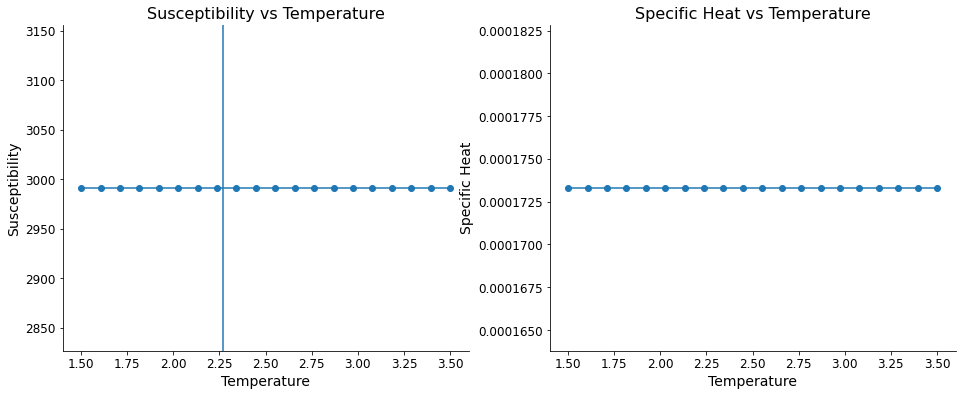

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

ax=ax1
ax.plot(temperatures, [r[0] for r in results])
ax.scatter(temperatures, [r[0] for r in results])
ax.axvline(T_critical)
ax.set_ylabel("Susceptibility")
ax.set_xlabel("Temperature")
ax.set_title("Susceptibility vs Temperature")

ax=ax2
ax.plot(temperatures, [r[1] for r in results])
ax.scatter(temperatures, [r[1] for r in results])
ax.set_ylabel("Specific Heat")
ax.set_xlabel("Temperature")
ax.set_title("Specific Heat vs Temperature")


### Exercise 4.15
Discuss whether or not your results proof the existence of a phase transition.

*Your answer here*

# Finding clusters
Given an Ising configuration, we define a cluster of spins as a set of neighbouring spins of the same sign surrounded by spins of the opposite sign.

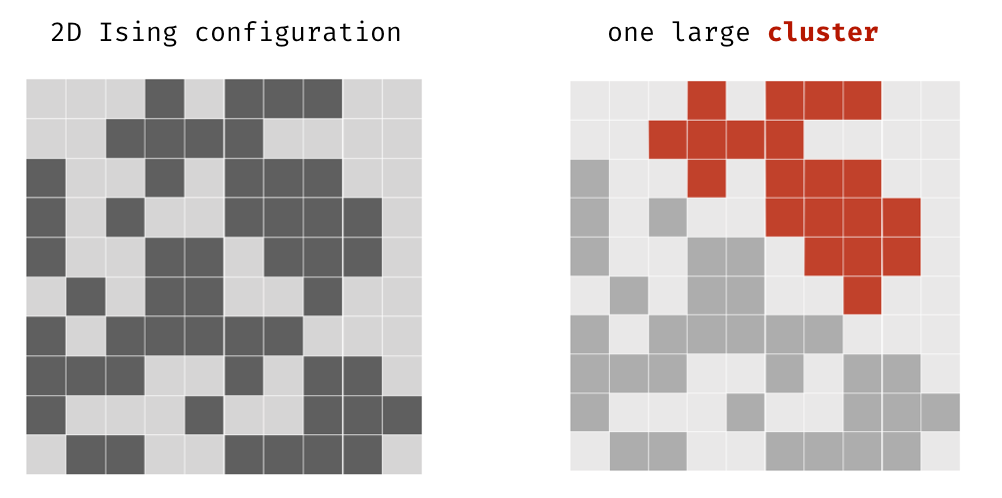

### Exercise 4.16
The formal definition of cluster is very clear, but in practice, how do you find (*efficiently* if possible) all clusters for a given configuration? We need to assign a **unique cluster label** to each spin. The cluster label could be anything (a color, a letter, a number...), it just needs to be the same for all spins that belong to the same cluster. For simplicity, we will use integers.

Think about an algorithm that assigns unique cluster labels to spins. Explain your algorithm in simple words / steps / pseudocode.

Remember:
+ Clusters can trespass (periodic) boundary conditions
+ Both `+1`'s and `-1`'s can form clusters!

*Your answer here*

### Exercise 4.17
Write a function that, given a configuration array `config`, returns another array `labels` where each cluster has a different label.

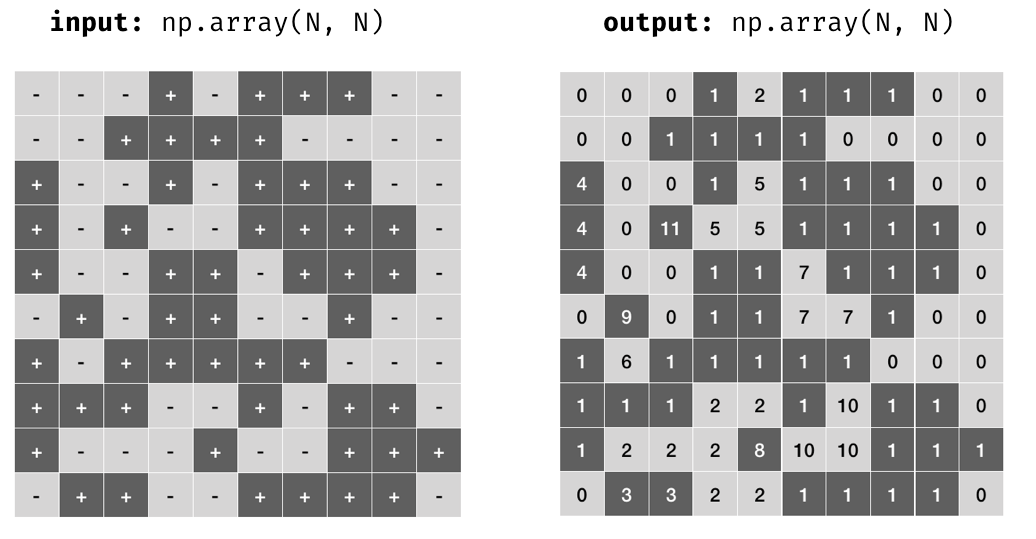

Remember:
+ Clusters can trespass (periodic) boundary conditions
+ Both `+1`'s and `-1`'s can form clusters!


In [30]:
from scipy.ndimage import label, generate_binary_structure
from labels import export_labeled_matrix, get_sizes
def get_labels_scipy(config):
    """
    Get unique cluster labels.
    
    Parameters
    ----------
    config : np.array, (N, N)
        Configuration of the system in {-1, 1} notation
    Returns
    -------
    labels : np.array, (N, N)
        Labels that identify the clusters
    """
    tempconfig = np.where(config==-1, 0, config)
    labeled_array, num_features = label(tempconfig)
            
    return labeled_array

### Test your function
To help you **test** your function, I have prepared some test data, so that we can all try our algorithms using the same input.

In [25]:
config_test_0 = np.array([[ 1,  1,  1],
                          [-1, -1,  1],
                          [-1, -1,  1]])
print(config_test_0,"\n")
print(export_labeled_matrix(config_test_0))

[[ 1  1  1]
 [-1 -1  1]
 [-1 -1  1]] 

[[1. 1. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [26]:
config_test_1 = np.array([[ 1, -1, -1,  1, -1,  1],
                          [-1, -1, -1,  1, -1,  1],
                          [-1,  1, -1, -1, -1,  1],
                          [-1,  1, -1,  1,  1,  1],
                          [-1,  1, -1, -1,  1, -1],
                          [-1, -1, -1,  1,  1,  1]])
print(config_test_1,"\n")
print(export_labeled_matrix(config_test_1))

[[ 1 -1 -1  1 -1  1]
 [-1 -1 -1  1 -1  1]
 [-1  1 -1 -1 -1  1]
 [-1  1 -1  1  1  1]
 [-1  1 -1 -1  1 -1]
 [-1 -1 -1  1  1  1]] 

[[2. 5. 5. 4. 5. 0.]
 [5. 5. 5. 4. 5. 0.]
 [5. 3. 5. 5. 5. 0.]
 [5. 3. 5. 0. 0. 0.]
 [5. 3. 5. 5. 0. 1.]
 [5. 5. 5. 0. 0. 0.]]


In [27]:
config_test_2 = np.array([[ 1, -1,  1,  1, -1,  1, -1,  1,  1,  1],
                          [-1, -1, -1,  1,  1, -1, -1, -1,  1, -1],
                          [ 1, -1,  1, -1, -1, -1,  1,  1, -1,  1],
                          [ 1, -1,  1,  1,  1, -1,  1, -1,  1, -1],
                          [-1, -1,  1,  1, -1,  1, -1,  1,  1,  1],
                          [ 1, -1, -1, -1,  1, -1,  1,  1, -1,  1],
                          [-1,  1, -1,  1,  1, -1, -1, -1,  1,  1],
                          [-1, -1, -1, -1,  1,  1, -1, -1, -1,  1],
                          [ 1,  1, -1, -1,  1, -1,  1,  1,  1,  1],
                          [ 1,  1, -1, -1, -1,  1,  1,  1,  1, -1]])
print(config_test_2,"\n")
print(export_labeled_matrix(config_test_2))

[[ 1 -1  1  1 -1  1 -1  1  1  1]
 [-1 -1 -1  1  1 -1 -1 -1  1 -1]
 [ 1 -1  1 -1 -1 -1  1  1 -1  1]
 [ 1 -1  1  1  1 -1  1 -1  1 -1]
 [-1 -1  1  1 -1  1 -1  1  1  1]
 [ 1 -1 -1 -1  1 -1  1  1 -1  1]
 [-1  1 -1  1  1 -1 -1 -1  1  1]
 [-1 -1 -1 -1  1  1 -1 -1 -1  1]
 [ 1  1 -1 -1  1 -1  1  1  1  1]
 [ 1  1 -1 -1 -1  1  1  1  1 -1]] 

[[ 2.  6.  8.  8. 14. 18. 10. 12. 12. 12.]
 [ 6.  6.  6.  8.  8. 10. 10. 10. 12.  3.]
 [ 4.  6.  1. 10. 10. 10. 17. 17. 16.  9.]
 [ 4.  6.  1.  1.  1. 10. 17.  7. 20. 23.]
 [ 6.  6.  1.  1. 13. 11. 19. 20. 20. 20.]
 [26.  6.  6.  6. 22. 24. 20. 20. 15. 20.]
 [ 6. 21.  6. 22. 22. 24. 24. 24. 20. 20.]
 [ 6.  6.  6.  6. 22. 22. 24. 24. 24. 20.]
 [ 0.  0.  6.  6. 22. 25. 20. 20. 20. 20.]
 [ 0.  0.  6.  6.  6. 20. 20. 20. 20.  5.]]


Execute the following cell to make sure your function works correctly. The left column will show the test configurations, and the right column will show the clusters your function found, with different clusters colored in different colors

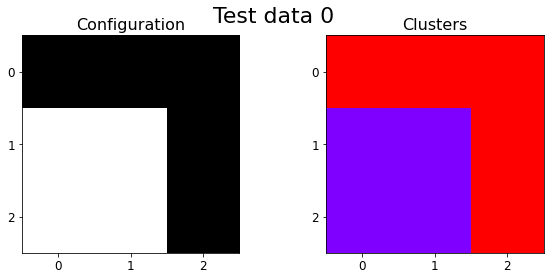

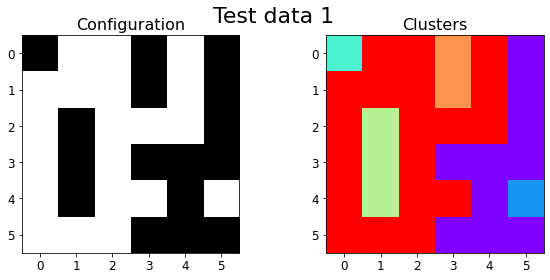

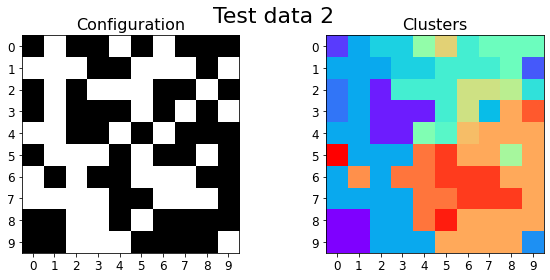

In [28]:
for i, config in enumerate([config_test_0, config_test_1, config_test_2]):
    labels = export_labeled_matrix(config)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
    ax1.set_xticks(range(len(config)))
    ax1.set_yticks(range(len(config)))
    ax2.set_xticks(range(len(config)))
    ax2.set_yticks(range(len(config)))
    ax1.set_title("Configuration")
    ax2.set_title("Clusters")
    ax1.imshow(config, cmap="Greys")
    ax2.imshow(labels, cmap="rainbow")
    
    fig.suptitle(f"Test data {i}", fontsize=22)

If your function doesn't work, you might want to use this cell to inspect your results

<AxesSubplot:>

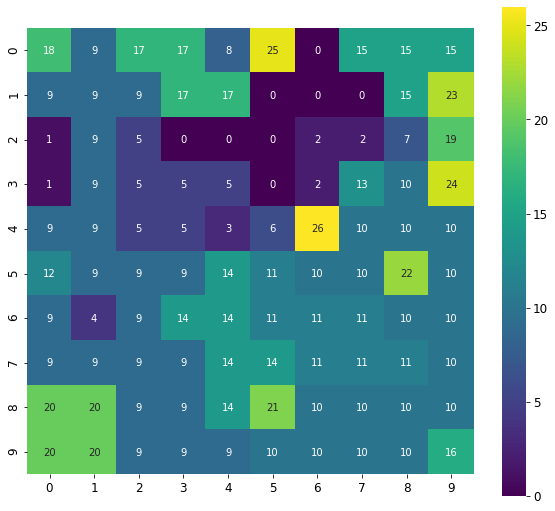

In [38]:
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(10, 9))
ax.set_aspect(1)
sns.heatmap(labels, annot=True, ax=ax, cmap="viridis")

### Measuring cluster sizes
Use your `get_labels()` function to find clusters in a large Ising model, say $N=500$. You can use your own Ising implementation. If you use Sethna's code, remember that he uses $s \in \{0, 1\}$ spins!

In [41]:
bigIsing = IsingModel(N=250)
labels = export_labeled_matrix(bigIsing.lattice)

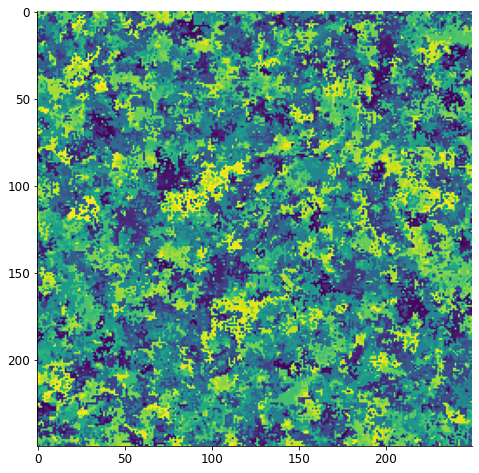

In [42]:
plt.figure(figsize=(10, 8))
plt.imshow(labels)

### Exercise 4.18
Find an efficient way to measure cluster sizes. Remind that all you care about is the distribution of cluster sizes, their location does not matter. You might want to use the `.reshape()` method of a numpy array, and the `Counter` class from the `collections` package.

In [ ]:
# See labels package 'get_size' function

### Exercise 4.19
For $T >> T_c$, spins are essentially uncorrelated. What is the distribution of cluster sizes you expect to find in this case? **Hint** Think about the 1D case assuming totally uncorrelated spins.

*Your answer here*



### Exercice 4.20
Do a simulation at very high temperature and measure the cluster size distribution. Plot your results in log-log scale. Do your results agree with your previous answer?

*Your answer here*

In [37]:
highT_Ising = IsingModel(N=100, T=30)
config = highT_Ising.lattice
labels = export_labeled_matrix(config)
sizes = get_sizes(labels)

(1, 267)

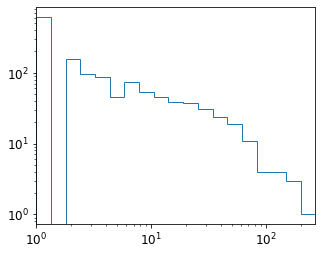

In [38]:
# use logarithmic bins and logarithmic axes!
bins = np.geomspace(min(sizes), max(sizes), num=20)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.hist(sizes, bins=bins, histtype="step")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(min(sizes), max(sizes))

### Exercise 4.21

At $T_c$, the distribution of cluster sizes is known to be a power law with exponent close to $\alpha \simeq 2$.

$$
P(s) \propto s^{-\alpha}
$$

Do a simulation at $T=T_c$ and compare the resulting cluster size distribution with that obtained at $T>>T_c$.

In [39]:
Tc_Ising = IsingModel(N=100, T=T_critical)
Tc_config = Tc_Ising.lattice
Tc_labels = export_labeled_matrix(Tc_config)
Tc_sizes = get_sizes(Tc_labels)

(1, 267)

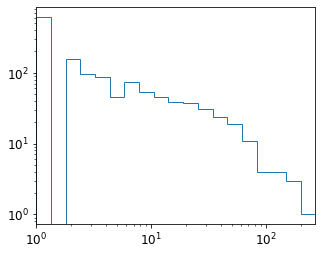

In [40]:
# use logarithmic bins and logarithmic axes!
Tc_bins = np.geomspace(min(Tc_sizes), max(Tc_sizes), num=20)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.hist(Tc_sizes, bins=Tc_bins, histtype="step")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(min(Tc_sizes), max(Tc_sizes))